<a href="https://colab.research.google.com/github/AndersieMichael/Thesis/blob/main/evaluasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
import pandas as pd
import os


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
# path_to_dataset = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/dataset/dataMerge'
path_to_dataset = '/content/drive/MyDrive/Colab/deep learning/dataset/dataMerge'
train_dir = os.path.join(path_to_dataset, 'train')
test_dir = os.path.join(path_to_dataset, 'test')
# val_dir = os.path.join(path_to_dataset, 'val')

# Contoh: Akses dan list file dalam direktori dataset

files = os.listdir(path_to_dataset)
print(files)

Mounted at /content/drive
['test', 'train', 'new_folder', 'new_folder2', 'train.cache', 'test.cache']


In [ ]:
!pip install pytictoc

In [ ]:
pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61395 sha256=2a64bef1abd45a7a401b2add522853c785a272a805a96579a856877925b64bc7
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31529 sha256=69a3864d99e8260af7bdae39347d6aa78493e6a8eed7090cfdb59194fabcaced
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [ ]:
#initialisasi variable

mystate =32
imageSize = 224
epochs = 50
batch_size = 64
learningRate=0.001
weight_decay=0.0005
input_size = (3, imageSize, imageSize)

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Pastikan ini muncul sebelum Normalize
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
from torchvision.io import read_image
from torchvision.transforms.functional import convert_image_dtype

In [ ]:
import torchvision.datasets as datasets

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Periksa distribusi kelas
class_counts = {}
for _, label in train_dataset:
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

class_names = train_dataset.classes

# Cetak informasi distribusi kelas
for class_name, count in zip(class_names, class_counts.values()):
    print(f"Class: {class_name}, Number of images: {count}")

Class: Acne, Number of images: 138
Class: Actinic Keratosis, Number of images: 138
Class: Basal Cell Carcinoma, Number of images: 138
Class: Eczemaa, Number of images: 138
Class: Rosacea, Number of images: 138


In [ ]:
def optimizer_Setting(model):
        return torch.optim.Adam(model.parameters(), lr=learningRate,  weight_decay = weight_decay)


In [ ]:
from torchvision.models import mobilenet_v3_small

# Load pretrained MobileNet V3 Small model
model_v3_small = mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model_v3_small.classifier[3] = nn.Linear(model_v3_small.classifier[3].in_features, len(class_names))  # Sesuaikan layer terakhir

# Membekukan layer terakhir (classifier)
for param in model_v3_small.classifier.parameters():
    param.requires_grad = False

# Membuka freeze untuk layer lainnya
for name, param in model_v3_small.named_parameters():
    if "classifier" not in name:
        param.requires_grad = True


# Kriteria dan optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model_v3_small.parameters(), lr=learningRate)
optimizer = optimizer_Setting(model_v3_small)

# Tentukan device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_v3_small = model_v3_small.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 143MB/s]


In [ ]:
import torch
from fvcore.nn import FlopCountAnalysis
from pytictoc import TicToc

from sklearn.metrics import accuracy_score

def validate(model, test_loader):
    model.eval()
    running_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    # Initialize TicToc
    t = TicToc()
    all_preds = []
    all_labels = []

 # Ambil satu batch data untuk menghitung FLOPs
    example_inputs, _ = next(iter(test_loader))
    example_inputs = example_inputs.to(next(model.parameters()).device)

    # Hitung FLOPs menggunakan fvcore
    flops = FlopCountAnalysis(model, example_inputs)
    total_flops = flops.total()
    print(f"Total FLOPs: {total_flops / 1e9} GFLOPs")
    gflops = total_flops / 1e9

    t.tic()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    t.toc()

    # Calculate average loss over all batches
    avg_loss = running_loss / len(test_loader)
    print(f'Average Loss: {avg_loss:.4f}')

    # Hitung akurasi
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Accuracy: {accuracy:.4f}')
    total_time = t.tocvalue()
    print(f'Total prediction time: {total_time:.2f} seconds')
    print(f'Accuracy: {accuracy:.4f}')

    return accuracy*100, total_time, gflops

In [ ]:
# mobileNetV3_small_save_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/pytorch code/mobileNetV3_small_best_model.pth'
mobileNetV3_small_save_path = '/content/drive/MyDrive/Colab/deep learning/mobileNetV3_small_best_model.pth'

# Menghitung total jumlah parameter
total_params_mbv3s = sum(p.numel() for p in model_v3_small.parameters())


In [ ]:

# Load model terbaik yang sudah disimpan
model_v3_small.load_state_dict(torch.load(mobileNetV3_small_save_path))

# Validasi model dan ukur waktu prediksi
mobileNetV3_smallResult_dummy, mobileNetV3_small_time_dummy, mobileNetV3_small_gflops_dummy = validate(model_v3_small, test_loader)

<ipython-input-17-5622a628b1f0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_v3_small.load_state_dict(torch.load(mobileNetV3_small_save_path))


Total FLOPs: 3.752361984 GFLOPs
Elapsed time is 75.904616 seconds.
Average Loss: 0.0000
Accuracy: 0.5946
Total prediction time: 75.91 seconds
Accuracy: 0.5946


In [ ]:

# Load model terbaik yang sudah disimpan
model_v3_small.load_state_dict(torch.load(mobileNetV3_small_save_path))

# Validasi model dan ukur waktu prediksi
mobileNetV3_smallResult, mobileNetV3_small_time, mobileNetV3_small_gflops = validate(model_v3_small, test_loader)

<ipython-input-18-90640932f5e7>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_v3_small.load_state_dict(torch.load(mobileNetV3_small_save_path))


Total FLOPs: 3.752361984 GFLOPs
Elapsed time is 2.060521 seconds.
Average Loss: 0.0000
Accuracy: 0.5946
Total prediction time: 2.06 seconds
Accuracy: 0.5946


In [ ]:
mobileNetV3_smallResult

59.45945945945946

In [ ]:
from torchvision.models import mobilenet_v3_large

# Load pretrained MobileNet V3 large model
model_v3_large = mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
model_v3_large.classifier[3] = nn.Linear(model_v3_large.classifier[3].in_features, len(class_names))  # Sesuaikan layer terakhir

# Membekukan layer terakhir (classifier)
for param in model_v3_large.classifier.parameters():
    param.requires_grad = False

# Membuka freeze untuk layer lainnya
for name, param in model_v3_large.named_parameters():
    if "classifier" not in name:
        param.requires_grad = True
# Kriteria dan optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model_v3_large.parameters(), lr=learningRate)
optimizer = optimizer_Setting(model_v3_large)

# Tentukan device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_v3_large = model_v3_large.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 23.5MB/s]


In [ ]:
# mobileNetV3_large_save_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/pytorch code/mobileNetV3_large_best_model.pth'
mobileNetV3_large_save_path = '/content/drive/MyDrive/Colab/deep learning/mobileNetV3_large_best_model.pth'

# Menghitung total jumlah parameter
total_params_mbv3l = sum(p.numel() for p in model_v3_large.parameters())

In [ ]:
# Load model terbaik yang sudah disimpan
model_v3_large.load_state_dict(torch.load(mobileNetV3_large_save_path))

# Validasi model dan ukur waktu prediksi
mobileNetV3_largeResult, mobileNetV3_large_time, mobileNetV3_large_gflops = validate(model_v3_large, test_loader)

<ipython-input-22-95a17027a037>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_v3_large.load_state_dict(torch.load(mobileNetV3_large_save_path))


Total FLOPs: 14.384654336 GFLOPs
Elapsed time is 2.440837 seconds.
Average Loss: 0.0000
Accuracy: 0.6486
Total prediction time: 2.44 seconds
Accuracy: 0.6486


In [ ]:
mobileNetV3_largeResult

64.86486486486487

In [ ]:
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

# Load pretrained EfficientNet B2 model
model_efficientnet_b2 = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)
model_efficientnet_b2.classifier[1] = nn.Linear(model_efficientnet_b2.classifier[1].in_features, len(class_names))

# Membekukan layer terakhir (classifier)
for param in model_efficientnet_b2.classifier.parameters():
    param.requires_grad = False

# Membuka freeze untuk layer lainnya
for name, param in model_efficientnet_b2.named_parameters():
    if "classifier" not in name:
        param.requires_grad = True

# Kriteria dan optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model_efficientnet_b2.parameters(), lr=learningRate)
optimizer = optimizer_Setting(model_efficientnet_b2)

# Tentukan device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_efficientnet_b2 = model_efficientnet_b2.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 39.7MB/s]


In [ ]:
# efficientNet_b2_save_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/pytorch code/efficientNet_b2_best_model.pth'
efficientNet_b2_save_path = '/content/drive/MyDrive/Colab/deep learning/efficientNet_b2_best_model.pth'

# Menghitung total jumlah parameter
total_params_efb2 = sum(p.numel() for p in model_efficientnet_b2.parameters())

In [ ]:
# efficientNet_b2Result, efficientNet_b2_time, efficientNet_b2_gflops = evaluate_model(model_efficientnet_b2, criterion, test_loader, efficientNet_b2_save_path)

# Load model terbaik yang sudah disimpan
model_efficientnet_b2.load_state_dict(torch.load(efficientNet_b2_save_path))

# Validasi model dan ukur waktu prediksi
efficientNet_b2Result, efficientNet_b2_time, efficientNet_b2_gflops = validate(model_efficientnet_b2, test_loader)

<ipython-input-26-34a557dc29a8>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_efficientnet_b2.load_state_dict(torch.load(efficientNet_b2_save_path))
features.1.0.st

Total FLOPs: 43.579193344 GFLOPs
Elapsed time is 2.811683 seconds.
Average Loss: 0.0000
Accuracy: 0.8324
Total prediction time: 2.81 seconds
Accuracy: 0.8324


In [ ]:
from torchvision.models import mobilenet_v2

# Load pretrained MobileNet V2 model
model_mobilenet_v2 = mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
model_mobilenet_v2.classifier[1] = nn.Linear(model_mobilenet_v2.classifier[1].in_features, len(class_names))

# Membekukan layer terakhir (classifier)
for param in model_mobilenet_v2.classifier.parameters():
    param.requires_grad = False

# Membuka freeze untuk layer lainnya
for name, param in model_mobilenet_v2.named_parameters():
    if "classifier" not in name:
        param.requires_grad = True

# Kriteria dan optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model_v3_large.parameters(), lr=learningRate)
optimizer = optimizer_Setting(model_mobilenet_v2)

# Tentukan device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_mobilenet_v2 = model_mobilenet_v2.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 151MB/s]


In [ ]:

# Contoh penggunaan fungsi
# Pastikan model_mobilenet_v2, criterion, test_loader, dan mobileNetV2_save_path sudah terdefinisi
# mobileNetV2_save_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/test skripsi/pytorch code/mobileNetV2_best_model.pth'
mobileNetV2_save_path = '/content/drive/MyDrive/Colab/deep learning/mobileNetV2_best_model.pth'

# Menghitung total jumlah parameter
total_params_mbv2 = sum(p.numel() for p in model_mobilenet_v2.parameters())

# mobileNetV2Result, mobileNetV2_time, mobileNetV2_gflops = evaluate_model(model_mobilenet_v2, criterion, test_loader, mobileNetV2_save_path)

In [ ]:
# Load model terbaik yang sudah disimpan
model_mobilenet_v2.load_state_dict(torch.load(mobileNetV2_save_path))

# Validasi model dan ukur waktu prediksi
mobileNetV2Result, mobileNetV2_time, mobileNetV2_gflops = validate(model_mobilenet_v2, test_loader)

<ipython-input-29-01b7cd83db9b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_mobilenet_v2.load_state_dict(torch.load(mobileNetV2_save_path))


Total FLOPs: 20.026855424 GFLOPs
Elapsed time is 2.114084 seconds.
Average Loss: 0.0000
Accuracy: 0.8000
Total prediction time: 2.12 seconds
Accuracy: 0.8000


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.1/874.1 kB 35.7 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
modelyolov8s = YOLO('yolov8s-cls.pt')  # load a pretrained YOLOv8n detection model
modelyolov8s.info()

100%|██████████| 12.3M/12.3M [00:00<00:00, 181MB/s]


YOLOv8s-cls summary: 99 layers, 6,361,736 parameters, 0 gradients, 13.6 GFLOPs


(99, 6361736, 0, 13.609779199999998)

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.101 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 36.7/112.6 GB disk)


In [ ]:
# Train the model
results = modelyolov8s.train(data='/content/drive/MyDrive/Colab/deep learning/dataset/dataMerge', epochs=epochs, imgsz=imageSize, lr0 = learningRate, optimizer = 'Adam', batch =batch_size , freeze = 1, name ='train1')

Ultralytics YOLOv8.2.101 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8s-cls.pt, data=/content/drive/MyDrive/Colab/deep learning/dataset/dataMerge, epochs=50, time=None, patience=100, batch=64, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train1, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=1, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, 

100%|██████████| 6.25M/6.25M [00:00<00:00, 176MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/Colab/deep learning/dataset/dataMerge/train... 690 images, 0 corrupt: 100%|██████████| 690/690 [00:00<?, ?it/s]
val: Scanning /content/drive/MyDrive/Colab/deep learning/dataset/dataMerge/test... 185 images, 0 corrupt: 100%|██████████| 185/185 [00:00<?, ?it/s]


optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/train1
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/50       8.9G      1.615         64        224:  36%|███▋      | 4/11 [00:04<00:05,  1.37it/s]


100%|██████████| 755k/755k [00:00<00:00, 38.4MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all      0.443          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 13.69it/s]

                   all      0.514          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 17.64it/s]

                   all      0.686          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 16.46it/s]

                   all      0.692          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 22.11it/s]

                   all      0.741          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 22.89it/s]

                   all      0.773          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 19.14it/s]

                   all      0.784          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 17.76it/s]

                   all      0.746          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 14.33it/s]


                   all      0.751          1

      Epoch    GPU_mem       loss  Instances       Size


      10/50      1.26G     0.3224         50        224: 100%|██████████| 11/11 [00:10<00:00,  1.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 30.17it/s]

                   all      0.784          1



      Epoch    GPU_mem       loss  Instances       Size


      11/50      1.27G     0.2837         50        224: 100%|██████████| 11/11 [00:13<00:00,  1.23s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 14.41it/s]


                   all      0.768          1

      Epoch    GPU_mem       loss  Instances       Size


      12/50      1.27G     0.3154         50        224: 100%|██████████| 11/11 [00:08<00:00,  1.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 11.67it/s]

                   all      0.784          1



      Epoch    GPU_mem       loss  Instances       Size


      13/50      1.27G     0.2736         50        224: 100%|██████████| 11/11 [00:10<00:00,  1.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 23.33it/s]

                   all      0.778          1



      Epoch    GPU_mem       loss  Instances       Size


      14/50      1.27G     0.2549         50        224: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 17.33it/s]

                   all      0.784          1



      Epoch    GPU_mem       loss  Instances       Size


      15/50      1.26G     0.2265         50        224: 100%|██████████| 11/11 [00:09<00:00,  1.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 17.03it/s]

                   all      0.751          1



      Epoch    GPU_mem       loss  Instances       Size


      16/50      1.27G     0.1907         50        224: 100%|██████████| 11/11 [00:09<00:00,  1.16it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 22.69it/s]

                   all      0.795          1



      Epoch    GPU_mem       loss  Instances       Size


      17/50      1.27G     0.1888         50        224: 100%|██████████| 11/11 [00:11<00:00,  1.08s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 20.65it/s]

                   all      0.773          1



      Epoch    GPU_mem       loss  Instances       Size


      18/50      1.27G     0.1962         50        224: 100%|██████████| 11/11 [00:08<00:00,  1.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 25.57it/s]

                   all      0.816          1



      Epoch    GPU_mem       loss  Instances       Size


      19/50      1.27G     0.1842         50        224: 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 18.77it/s]

                   all      0.816          1



      Epoch    GPU_mem       loss  Instances       Size


      20/50      1.26G      0.155         50        224: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 16.80it/s]

                   all      0.811          1



      Epoch    GPU_mem       loss  Instances       Size


      21/50      1.27G      0.163         50        224: 100%|██████████| 11/11 [00:07<00:00,  1.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 21.72it/s]

                   all      0.784          1



      Epoch    GPU_mem       loss  Instances       Size


      22/50      1.27G     0.1218         50        224: 100%|██████████| 11/11 [00:12<00:00,  1.12s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 19.62it/s]

                   all      0.827          1



      Epoch    GPU_mem       loss  Instances       Size


      23/50      1.27G     0.1117         50        224: 100%|██████████| 11/11 [00:10<00:00,  1.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 10.76it/s]

                   all      0.811          1



      Epoch    GPU_mem       loss  Instances       Size


      24/50      1.27G     0.1361         50        224: 100%|██████████| 11/11 [00:07<00:00,  1.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 14.96it/s]

                   all      0.784          1



      Epoch    GPU_mem       loss  Instances       Size


      25/50      1.26G     0.1199         50        224: 100%|██████████| 11/11 [00:12<00:00,  1.09s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 21.05it/s]

                   all      0.795          1



      Epoch    GPU_mem       loss  Instances       Size


      26/50      1.27G     0.1225         50        224: 100%|██████████| 11/11 [00:09<00:00,  1.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 21.71it/s]

                   all      0.778          1



      Epoch    GPU_mem       loss  Instances       Size


      27/50      1.27G     0.1364         50        224: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 29.23it/s]

                   all        0.8          1



      Epoch    GPU_mem       loss  Instances       Size


      28/50      1.27G       0.12         50        224: 100%|██████████| 11/11 [00:11<00:00,  1.07s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 19.80it/s]

                   all        0.8          1



      Epoch    GPU_mem       loss  Instances       Size


      29/50      1.27G     0.1154         50        224: 100%|██████████| 11/11 [00:09<00:00,  1.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 12.14it/s]

                   all      0.811          1



      Epoch    GPU_mem       loss  Instances       Size


      30/50      1.26G    0.09966         50        224: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 14.94it/s]

                   all      0.811          1



      Epoch    GPU_mem       loss  Instances       Size


      31/50      1.27G    0.09015         50        224: 100%|██████████| 11/11 [00:12<00:00,  1.14s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 21.89it/s]

                   all      0.789          1



      Epoch    GPU_mem       loss  Instances       Size


      32/50      1.27G      0.104         50        224: 100%|██████████| 11/11 [00:07<00:00,  1.40it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 20.96it/s]

                   all      0.789          1



      Epoch    GPU_mem       loss  Instances       Size


      33/50      1.27G     0.1298         50        224: 100%|██████████| 11/11 [00:12<00:00,  1.13s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 24.45it/s]

                   all      0.805          1



      Epoch    GPU_mem       loss  Instances       Size


      34/50      1.27G    0.06791         50        224: 100%|██████████| 11/11 [00:10<00:00,  1.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 12.89it/s]

                   all      0.811          1



      Epoch    GPU_mem       loss  Instances       Size


      35/50      1.26G    0.04956         50        224: 100%|██████████| 11/11 [00:08<00:00,  1.35it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 20.03it/s]

                   all      0.805          1



      Epoch    GPU_mem       loss  Instances       Size


      36/50      1.27G    0.04513         50        224: 100%|██████████| 11/11 [00:11<00:00,  1.08s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 17.89it/s]

                   all      0.832          1



      Epoch    GPU_mem       loss  Instances       Size


      37/50      1.27G    0.04695         50        224: 100%|██████████| 11/11 [00:10<00:00,  1.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 13.12it/s]

                   all      0.805          1



      Epoch    GPU_mem       loss  Instances       Size


      38/50      1.27G    0.07334         50        224: 100%|██████████| 11/11 [00:07<00:00,  1.51it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 21.70it/s]

                   all      0.822          1



      Epoch    GPU_mem       loss  Instances       Size


      39/50      1.27G    0.04134         50        224: 100%|██████████| 11/11 [00:12<00:00,  1.12s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 16.25it/s]

                   all      0.811          1



      Epoch    GPU_mem       loss  Instances       Size


      40/50      1.26G    0.04848         50        224: 100%|██████████| 11/11 [00:08<00:00,  1.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 16.94it/s]

                   all      0.822          1



      Epoch    GPU_mem       loss  Instances       Size


      41/50      1.27G    0.04769         50        224: 100%|██████████| 11/11 [00:08<00:00,  1.35it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 16.22it/s]

                   all      0.822          1



      Epoch    GPU_mem       loss  Instances       Size


      42/50      1.27G    0.06067         50        224: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 17.74it/s]

                   all      0.811          1



      Epoch    GPU_mem       loss  Instances       Size


      43/50      1.27G    0.06661         50        224: 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 12.18it/s]

                   all      0.822          1



      Epoch    GPU_mem       loss  Instances       Size


      44/50      1.27G    0.05203         50        224: 100%|██████████| 11/11 [00:07<00:00,  1.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 26.49it/s]

                   all      0.827          1



      Epoch    GPU_mem       loss  Instances       Size


      45/50      1.26G    0.05466         50        224: 100%|██████████| 11/11 [00:12<00:00,  1.10s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 21.62it/s]

                   all      0.838          1



      Epoch    GPU_mem       loss  Instances       Size


      46/50      1.27G    0.02939         50        224: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 14.08it/s]

                   all      0.832          1



      Epoch    GPU_mem       loss  Instances       Size


      47/50      1.27G    0.03428         50        224: 100%|██████████| 11/11 [00:09<00:00,  1.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 27.72it/s]

                   all      0.843          1



      Epoch    GPU_mem       loss  Instances       Size


      48/50      1.27G    0.03713         50        224: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 21.14it/s]

                   all      0.843          1



      Epoch    GPU_mem       loss  Instances       Size


      49/50      1.27G    0.03656         50        224: 100%|██████████| 11/11 [00:10<00:00,  1.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 21.65it/s]

                   all      0.832          1



      Epoch    GPU_mem       loss  Instances       Size


      50/50      1.26G    0.02558         50        224: 100%|██████████| 11/11 [00:08<00:00,  1.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 21.81it/s]

                   all      0.843          1



50 epochs completed in 0.177 hours.
Optimizer stripped from runs/classify/train1/weights/last.pt, 10.3MB
Optimizer stripped from runs/classify/train1/weights/best.pt, 10.3MB

Validating runs/classify/train1/weights/best.pt...
Ultralytics YOLOv8.2.101 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-cls summary (fused): 73 layers, 5,081,605 parameters, 0 gradients, 12.5 GFLOPs
WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.
train: /content/drive/MyDrive/Colab/deep learning/dataset/dataMerge/train... found 690 images in 5 classes ✅ 
val: None...
test: /content/drive/MyDrive/Colab/deep learning/dataset/dataMerge/test... found 185 images in 5 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00,  8.57it/s]


                   all      0.843          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train1
Results saved to runs/classify/train1


In [ ]:
bestModelYoloS = YOLO('/content/runs/classify/train1/weights/best.pt')  # load a custom model

In [ ]:
# Total parameter untuk masing-masing model
path_class = ['/content/drive/MyDrive/Colab/deep learning/dataset/dataMerge/test/Acne',
              '/content/drive/MyDrive/Colab/deep learning/dataset/dataMerge/test/Actinic Keratosis',
              '/content/drive/MyDrive/Colab/deep learning/dataset/dataMerge/test/Basal Cell Carcinoma',
              '/content/drive/MyDrive/Colab/deep learning/dataset/dataMerge/test/Eczemaa',
              '/content/drive/MyDrive/Colab/deep learning/dataset/dataMerge/test/Rosacea']

In [ ]:
def evaluate_model_yolo(model, model_path, device=None):
  # Setup TicToc
  t = TicToc()
  # List to store prediction results
  prediction_tests = []
  if device is None:
        # Automatically choose the device: Use GPU if available, else CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Move model to the selected device
  model.to(device)
  t.tic()  # Start timing
  # Proses untuk setiap predictionTest
  for i in range(5):
    prediction_result = model.predict(model_path[i])
    prediction_tests.append(prediction_result)

  t.toc()  # Stop timing and get total time
  # Menggunakan total waktu evaluasi
  elapsed_time_s = t.elapsed
  print(f"Total Prediction Time: {elapsed_time_s:.2f} seconds")

  return prediction_tests, elapsed_time_s

In [ ]:
prediction_tests,total_inference_time_yolov8S_percobaan = evaluate_model_yolo(bestModelYoloS,path_class)


image 1/37 /content/drive/MyDrive/Colab/deep learning/dataset/dataMerge/test/Acne/032839HB.jpg: 224x224 Acne 0.93, Rosacea 0.06, Eczemaa 0.01, Actinic Keratosis 0.00, Basal Cell Carcinoma 0.00, 5.3ms
image 2/37 /content/drive/MyDrive/Colab/deep learning/dataset/dataMerge/test/Acne/032897HB.jpg: 224x224 Acne 1.00, Rosacea 0.00, Eczemaa 0.00, Actinic Keratosis 0.00, Basal Cell Carcinoma 0.00, 5.4ms
image 3/37 /content/drive/MyDrive/Colab/deep learning/dataset/dataMerge/test/Acne/07AcnePittedScars1.jpg: 224x224 Acne 1.00, Basal Cell Carcinoma 0.00, Actinic Keratosis 0.00, Eczemaa 0.00, Rosacea 0.00, 9.3ms
image 4/37 /content/drive/MyDrive/Colab/deep learning/dataset/dataMerge/test/Acne/acne-Closed-Comedo.jpg: 224x224 Basal Cell Carcinoma 0.78, Acne 0.19, Actinic Keratosis 0.03, Rosacea 0.00, Eczemaa 0.00, 7.0ms
image 5/37 /content/drive/MyDrive/Colab/deep learning/dataset/dataMerge/test/Acne/acne-closed-comedo-8.jpg: 224x224 Acne 1.00, Basal Cell Carcinoma 0.00, Actinic Keratosis 0.00, R

In [ ]:
total_inference_time_yolov8S_percobaan

5.8891545750000205

In [ ]:
total_correct_predictions = 0
total_all_predictions = 0
total_running_loss = 0.0  # to accumulate the total loss


# Proses untuk setiap predictionTest
for i, predictionTest in enumerate(prediction_tests):
    correct_predictions = 0
    true_label = i  # karena semua ground truth di predictionTesti adalah i

    for result in predictionTest:
        predicted_label = result.probs.top1  # asumsi bahwa probs.top1 adalah label prediksi teratas
        if predicted_label == true_label:
            correct_predictions += 1

    # Jumlah total prediksi untuk setiap kelas
    total_predictions = len(predictionTest)
    total_all_predictions += total_predictions
    total_correct_predictions += correct_predictions

    # Akurasi untuk kelas ini
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"Akurasi untuk predictionTest{i}: {accuracy:.2f}%")

# Akurasi keseluruhan
overall_accuracy_yolov8S = (total_correct_predictions / total_all_predictions) * 100

print(f"Akurasi keseluruhan model: {overall_accuracy_yolov8S:.2f}%")
# print(f"Total waktu inferensi: {total_inference_time_yolov8S:.2f} detik")

Akurasi untuk predictionTest0: 91.89%
Akurasi untuk predictionTest1: 81.08%
Akurasi untuk predictionTest2: 78.38%
Akurasi untuk predictionTest3: 83.78%
Akurasi untuk predictionTest4: 83.78%
Akurasi keseluruhan model: 83.78%


In [ ]:
modelyolov8n = YOLO('yolov8n-cls.pt')  # load a pretrained YOLOv8n detection model
modelyolov8n.info()

100%|██████████| 5.31M/5.31M [00:00<00:00, 122MB/s]


YOLOv8n-cls summary: 99 layers, 2,719,288 parameters, 0 gradients, 4.4 GFLOPs


(99, 2719288, 0, 4.383948800000001)

In [ ]:
# Train the model
results = modelyolov8n.train(data='/content/drive/MyDrive/Colab/deep learning/dataset/dataMerge', epochs=epochs, imgsz=imageSize, lr0 = learningRate, optimizer = 'Adam', batch =batch_size , freeze = 1, name ='train2')

Ultralytics YOLOv8.2.101 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/content/drive/MyDrive/Colab/deep learning/dataset/dataMerge, epochs=50, time=None, patience=100, batch=64, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=1, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, 

train: Scanning /content/drive/MyDrive/Colab/deep learning/dataset/dataMerge/train... 690 images, 0 corrupt: 100%|██████████| 690/690 [00:00<?, ?it/s]
val: Scanning /content/drive/MyDrive/Colab/deep learning/dataset/dataMerge/test... 185 images, 0 corrupt: 100%|██████████| 185/185 [00:00<?, ?it/s]


optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/train2
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all        0.4          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 34.81it/s]

                   all      0.514          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 13.16it/s]

                   all      0.578          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 25.18it/s]

                   all      0.686          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 28.62it/s]

                   all      0.681          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 16.92it/s]

                   all      0.703          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 28.15it/s]

                   all       0.73          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 11.70it/s]

                   all      0.686          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 27.19it/s]

                   all      0.708          1



      Epoch    GPU_mem       loss  Instances       Size


      10/50      0.81G     0.4513         50        224: 100%|██████████| 11/11 [00:14<00:00,  1.29s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 17.40it/s]

                   all      0.751          1



      Epoch    GPU_mem       loss  Instances       Size


      11/50      0.81G     0.4295         50        224: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 11.66it/s]


                   all      0.768          1

      Epoch    GPU_mem       loss  Instances       Size


      12/50      0.81G     0.4104         50        224: 100%|██████████| 11/11 [00:10<00:00,  1.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 27.08it/s]

                   all      0.773          1



      Epoch    GPU_mem       loss  Instances       Size


      13/50      0.81G     0.3412         50        224: 100%|██████████| 11/11 [00:10<00:00,  1.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 21.03it/s]

                   all      0.773          1



      Epoch    GPU_mem       loss  Instances       Size


      14/50      0.81G     0.3813         50        224: 100%|██████████| 11/11 [00:10<00:00,  1.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 30.40it/s]

                   all      0.762          1



      Epoch    GPU_mem       loss  Instances       Size


      15/50      0.81G     0.3206         50        224: 100%|██████████| 11/11 [00:12<00:00,  1.14s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00,  9.26it/s]

                   all      0.762          1



      Epoch    GPU_mem       loss  Instances       Size


      16/50      0.81G     0.2582         50        224: 100%|██████████| 11/11 [00:08<00:00,  1.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 26.28it/s]

                   all      0.757          1



      Epoch    GPU_mem       loss  Instances       Size


      17/50      0.81G     0.2689         50        224: 100%|██████████| 11/11 [00:13<00:00,  1.20s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 37.12it/s]

                   all      0.773          1



      Epoch    GPU_mem       loss  Instances       Size


      18/50      0.81G     0.2556         50        224: 100%|██████████| 11/11 [00:10<00:00,  1.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 36.72it/s]

                   all      0.757          1



      Epoch    GPU_mem       loss  Instances       Size


      19/50      0.81G     0.2425         50        224: 100%|██████████| 11/11 [00:10<00:00,  1.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 30.87it/s]

                   all      0.778          1



      Epoch    GPU_mem       loss  Instances       Size


      20/50      0.81G     0.2417         50        224: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 15.06it/s]

                   all      0.784          1



      Epoch    GPU_mem       loss  Instances       Size


      21/50      0.81G     0.1979         50        224: 100%|██████████| 11/11 [00:08<00:00,  1.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 25.45it/s]

                   all      0.768          1



      Epoch    GPU_mem       loss  Instances       Size


      22/50      0.81G     0.1676         50        224: 100%|██████████| 11/11 [00:12<00:00,  1.16s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 14.02it/s]

                   all      0.778          1



      Epoch    GPU_mem       loss  Instances       Size


      23/50      0.81G     0.1618         50        224: 100%|██████████| 11/11 [00:07<00:00,  1.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 26.34it/s]

                   all      0.795          1



      Epoch    GPU_mem       loss  Instances       Size


      24/50      0.81G     0.2113         50        224: 100%|██████████| 11/11 [00:13<00:00,  1.23s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 31.69it/s]

                   all      0.805          1



      Epoch    GPU_mem       loss  Instances       Size


      25/50      0.81G     0.1681         50        224: 100%|██████████| 11/11 [00:08<00:00,  1.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 29.07it/s]

                   all      0.805          1



      Epoch    GPU_mem       loss  Instances       Size


      26/50      0.81G     0.1476         50        224: 100%|██████████| 11/11 [00:14<00:00,  1.28s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 33.73it/s]

                   all      0.822          1



      Epoch    GPU_mem       loss  Instances       Size


      27/50      0.81G     0.1836         50        224: 100%|██████████| 11/11 [00:09<00:00,  1.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 16.11it/s]


                   all      0.822          1

      Epoch    GPU_mem       loss  Instances       Size


      28/50      0.81G     0.1823         50        224: 100%|██████████| 11/11 [00:11<00:00,  1.07s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 20.97it/s]

                   all      0.778          1



      Epoch    GPU_mem       loss  Instances       Size


      29/50      0.81G     0.1483         50        224: 100%|██████████| 11/11 [00:11<00:00,  1.04s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 12.77it/s]


                   all      0.768          1

      Epoch    GPU_mem       loss  Instances       Size


      30/50      0.81G     0.1348         50        224: 100%|██████████| 11/11 [00:08<00:00,  1.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 35.21it/s]

                   all      0.805          1



      Epoch    GPU_mem       loss  Instances       Size


      31/50      0.81G     0.1461         50        224: 100%|██████████| 11/11 [00:12<00:00,  1.18s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 31.75it/s]

                   all      0.789          1



      Epoch    GPU_mem       loss  Instances       Size


      32/50      0.81G     0.1278         50        224: 100%|██████████| 11/11 [00:09<00:00,  1.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 34.78it/s]

                   all      0.816          1



      Epoch    GPU_mem       loss  Instances       Size


      33/50      0.81G     0.1509         50        224: 100%|██████████| 11/11 [00:12<00:00,  1.11s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 32.09it/s]


                   all      0.789          1

      Epoch    GPU_mem       loss  Instances       Size


      34/50      0.81G     0.1279         50        224: 100%|██████████| 11/11 [00:10<00:00,  1.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 20.69it/s]

                   all        0.8          1



      Epoch    GPU_mem       loss  Instances       Size


      35/50      0.81G    0.09734         50        224: 100%|██████████| 11/11 [00:09<00:00,  1.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 29.00it/s]

                   all      0.827          1



      Epoch    GPU_mem       loss  Instances       Size


      36/50      0.81G     0.1146         50        224: 100%|██████████| 11/11 [00:10<00:00,  1.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 13.32it/s]

                   all      0.778          1



      Epoch    GPU_mem       loss  Instances       Size


      37/50      0.81G    0.09969         50        224: 100%|██████████| 11/11 [00:09<00:00,  1.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 34.67it/s]

                   all      0.795          1



      Epoch    GPU_mem       loss  Instances       Size


      38/50      0.81G     0.1144         50        224: 100%|██████████| 11/11 [00:13<00:00,  1.24s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 28.22it/s]

                   all        0.8          1



      Epoch    GPU_mem       loss  Instances       Size


      39/50      0.81G     0.1001         50        224: 100%|██████████| 11/11 [00:07<00:00,  1.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 26.11it/s]

                   all      0.811          1



      Epoch    GPU_mem       loss  Instances       Size


      40/50      0.81G    0.06927         50        224: 100%|██████████| 11/11 [00:13<00:00,  1.21s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 28.55it/s]

                   all      0.805          1



      Epoch    GPU_mem       loss  Instances       Size


      41/50      0.81G     0.1019         50        224: 100%|██████████| 11/11 [00:10<00:00,  1.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00,  9.74it/s]

                   all      0.811          1



      Epoch    GPU_mem       loss  Instances       Size


      42/50      0.81G     0.1018         50        224: 100%|██████████| 11/11 [00:07<00:00,  1.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 25.04it/s]

                   all      0.816          1



      Epoch    GPU_mem       loss  Instances       Size


      43/50      0.81G     0.1097         50        224: 100%|██████████| 11/11 [00:13<00:00,  1.19s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00,  9.75it/s]

                   all      0.816          1



      Epoch    GPU_mem       loss  Instances       Size


      44/50      0.81G    0.08825         50        224: 100%|██████████| 11/11 [00:07<00:00,  1.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 23.73it/s]

                   all      0.822          1



      Epoch    GPU_mem       loss  Instances       Size


      45/50      0.81G    0.09169         50        224: 100%|██████████| 11/11 [00:13<00:00,  1.24s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 23.91it/s]

                   all      0.822          1



      Epoch    GPU_mem       loss  Instances       Size


      46/50      0.81G    0.08112         50        224: 100%|██████████| 11/11 [00:08<00:00,  1.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 27.52it/s]

                   all      0.822          1



      Epoch    GPU_mem       loss  Instances       Size


      47/50      0.81G    0.07966         50        224: 100%|██████████| 11/11 [00:12<00:00,  1.15s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 21.96it/s]

                   all      0.816          1



      Epoch    GPU_mem       loss  Instances       Size


      48/50      0.81G    0.06693         50        224: 100%|██████████| 11/11 [00:09<00:00,  1.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 15.70it/s]

                   all      0.811          1



      Epoch    GPU_mem       loss  Instances       Size


      49/50      0.81G    0.08196         50        224: 100%|██████████| 11/11 [00:10<00:00,  1.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 30.95it/s]

                   all      0.811          1



      Epoch    GPU_mem       loss  Instances       Size


      50/50      0.81G    0.06605         50        224: 100%|██████████| 11/11 [00:10<00:00,  1.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 10.54it/s]

                   all      0.811          1



50 epochs completed in 0.185 hours.
Optimizer stripped from runs/classify/train2/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train2/weights/best.pt, 3.0MB

Validating runs/classify/train2/weights/best.pt...
Ultralytics YOLOv8.2.101 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,441,285 parameters, 0 gradients, 3.3 GFLOPs
WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.
train: /content/drive/MyDrive/Colab/deep learning/dataset/dataMerge/train... found 690 images in 5 classes ✅ 
val: None...
test: /content/drive/MyDrive/Colab/deep learning/dataset/dataMerge/test... found 185 images in 5 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 2/2 [00:00<00:00, 21.42it/s]


                   all      0.827          1
Speed: 0.1ms preprocess, 0.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2
Results saved to runs/classify/train2


In [ ]:
bestModelYoloN = YOLO('/content/runs/classify/train2/weights/best.pt')  # load a custom model

In [ ]:
prediction_tests_yolov8N,total_inference_time_yolov8N_percobaan = evaluate_model_yolo(bestModelYoloN,path_class)


image 1/37 /content/drive/MyDrive/Colab/deep learning/dataset/dataMerge/test/Acne/032839HB.jpg: 224x224 Eczemaa 0.96, Acne 0.03, Rosacea 0.01, Basal Cell Carcinoma 0.00, Actinic Keratosis 0.00, 3.4ms
image 2/37 /content/drive/MyDrive/Colab/deep learning/dataset/dataMerge/test/Acne/032897HB.jpg: 224x224 Acne 0.47, Rosacea 0.42, Eczemaa 0.11, Actinic Keratosis 0.00, Basal Cell Carcinoma 0.00, 3.5ms
image 3/37 /content/drive/MyDrive/Colab/deep learning/dataset/dataMerge/test/Acne/07AcnePittedScars1.jpg: 224x224 Acne 0.99, Actinic Keratosis 0.01, Basal Cell Carcinoma 0.00, Rosacea 0.00, Eczemaa 0.00, 3.1ms
image 4/37 /content/drive/MyDrive/Colab/deep learning/dataset/dataMerge/test/Acne/acne-Closed-Comedo.jpg: 224x224 Actinic Keratosis 0.71, Acne 0.26, Rosacea 0.02, Basal Cell Carcinoma 0.01, Eczemaa 0.00, 2.9ms
image 5/37 /content/drive/MyDrive/Colab/deep learning/dataset/dataMerge/test/Acne/acne-closed-comedo-8.jpg: 224x224 Acne 1.00, Actinic Keratosis 0.00, Basal Cell Carcinoma 0.00, E

In [ ]:
total_correct_predictions = 0
total_all_predictions = 0

# Proses untuk setiap predictionTest
for i, predictionTest in enumerate(prediction_tests_yolov8N):
    correct_predictions = 0
    true_label = i  # karena semua ground truth di predictionTesti adalah i

    for result in predictionTest:
        predicted_label = result.probs.top1  # asumsi bahwa probs.top1 adalah label prediksi teratas
        if predicted_label == true_label:
            correct_predictions += 1

    # Jumlah total prediksi untuk setiap kelas
    total_predictions = len(predictionTest)
    total_all_predictions += total_predictions
    total_correct_predictions += correct_predictions

    # Akurasi untuk kelas ini
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"Akurasi untuk predictionTest{i}: {accuracy:.2f}%")

# Akurasi keseluruhan
overall_accuracy_yolov8N = (total_correct_predictions / total_all_predictions) * 100

print(f"Akurasi keseluruhan model: {overall_accuracy_yolov8N:.2f}%")
# print(f"Total waktu inferensi: {total_inference_time_yolov8S:.2f} detik")

Akurasi untuk predictionTest0: 89.19%
Akurasi untuk predictionTest1: 86.49%
Akurasi untuk predictionTest2: 70.27%
Akurasi untuk predictionTest3: 83.78%
Akurasi untuk predictionTest4: 83.78%
Akurasi keseluruhan model: 82.70%


In [ ]:
# Membuat array string
array_model = ["MobileNetV2", "MobileNetV3Small", "MobileNetV3Large", "EfficientNetB2" , "YOLOV8N-cls", "YOLOV8S-cls"]

# Menampilkan array string
print(array_model)

['MobileNetV2', 'MobileNetV3Small', 'MobileNetV3Large', 'EfficientNetB2', 'YOLOV8N-cls', 'YOLOV8S-cls']


In [ ]:
best_accuracies = [mobileNetV2Result, mobileNetV3_smallResult, mobileNetV3_largeResult, efficientNet_b2Result, overall_accuracy_yolov8N, overall_accuracy_yolov8S]

In [ ]:
best_accuracies

[80.0,
 59.45945945945946,
 64.86486486486487,
 83.24324324324324,
 82.70270270270271,
 83.78378378378379]

In [ ]:
import matplotlib.pyplot as plt

def plot_model_inference_time(model_names, accuracies, inference_times ):
    # Membuat scatter plot
    plt.figure(figsize=(10, 5))
    for i in range(len(model_names)):
        plt.scatter(inference_times[i], accuracies[i], label=model_names[i])

    # Menambahkan judul dan label
    plt.title('Relationship Between Inference Time and Model Accuracy')
    plt.xlabel('Inference Time (seconds)')
    plt.ylabel('Accuracy (%)')

    # Menambahkan legenda
    plt.legend()

    # Menampilkan grid
    plt.grid(True)

    # Menampilkan grafik
    plt.show()

In [ ]:
inference_times = [mobileNetV2_time, mobileNetV3_small_time, mobileNetV3_large_time, efficientNet_b2_time, total_inference_time_yolov8N_percobaan,  total_inference_time_yolov8S_percobaan]

In [ ]:
inference_times

[2.11624112100003,
 2.062641633999988,
 2.4430919720000475,
 2.814097531000016,
 4.720222062999937,
 5.8891545750000205]

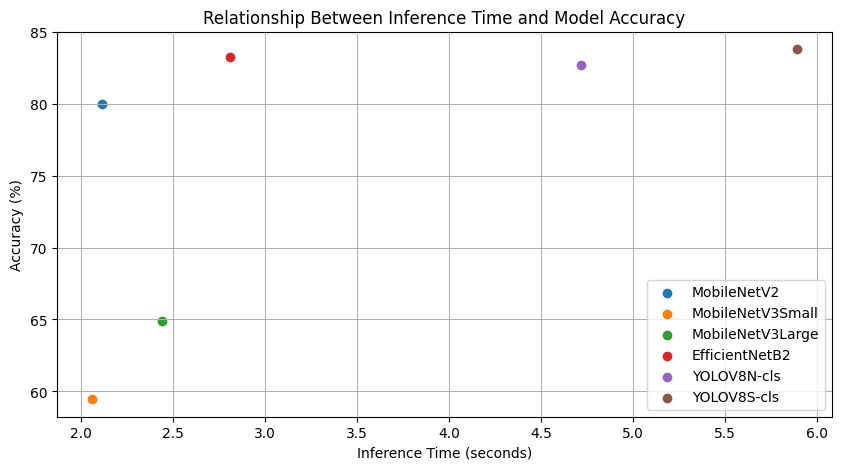

In [ ]:
plot_model_inference_time(array_model, best_accuracies, inference_times)

In [ ]:
def get_gflops_input(prompt):
    while True:
        try:
            # Meminta input dari pengguna
            user_input = input(prompt)
            # Mengkonversi input ke tipe float
            gflops = float(user_input)
            if gflops < 0:
                raise ValueError("GFLOPs tidak boleh negatif.")
            return gflops
        except ValueError as e:
            # Jika konversi gagal atau input negatif, berikan pesan kesalahan dan minta lagi
            print("Error:", e)
            print("Silakan masukkan angka yang valid untuk GFLOPs.")

In [ ]:
modelyolov8n.info()

YOLOv8n-cls summary: 99 layers, 1,444,693 parameters, 0 gradients, 3.4 GFLOPs


(99, 1444693, 0, 3.3650687999999995)

In [ ]:
# Meminta pengguna memasukkan GFLOPs
gflops_yoloV8n = get_gflops_input("Masukkan jumlah GFLOPs: ")
print("Jumlah GFLOPs yang Anda masukkan adalah:", gflops_yoloV8n)


Masukkan jumlah GFLOPs: 3.4 
Jumlah GFLOPs yang Anda masukkan adalah: 3.4


In [ ]:
modelyolov8s.info()

YOLOv8s-cls summary: 99 layers, 5,087,141 parameters, 0 gradients, 12.6 GFLOPs


(99, 5087141, 0, 12.5908992)

In [ ]:
# Meminta pengguna memasukkan GFLOPs
gflops_yoloV8s = get_gflops_input("Masukkan jumlah GFLOPs: ")
print("Jumlah GFLOPs yang Anda masukkan adalah:", gflops_yoloV8s)


Masukkan jumlah GFLOPs: 12.6 
Jumlah GFLOPs yang Anda masukkan adalah: 12.6


In [ ]:
Glops_model = [mobileNetV2_gflops, mobileNetV3_small_gflops, mobileNetV3_large_gflops, efficientNet_b2_gflops, gflops_yoloV8n,  gflops_yoloV8s]

In [ ]:
def plot_model_Gflops(model_names, accuracies, flops):
    # Membuat scatter plot
    plt.figure(figsize=(10, 5))
    for i in range(len(model_names)):
        plt.scatter(flops[i], accuracies[i], label=model_names[i])

    # Menambahkan judul dan label
    plt.title('The Relationship Between FLOPs and Model Accuracy')
    plt.xlabel('FLOPs (GFLOPs)')
    plt.ylabel('Accuracy (%)')

    # Menambahkan legenda
    plt.legend()

    # Menampilkan grid
    plt.grid(True)

    # Menampilkan grafik
    plt.show()


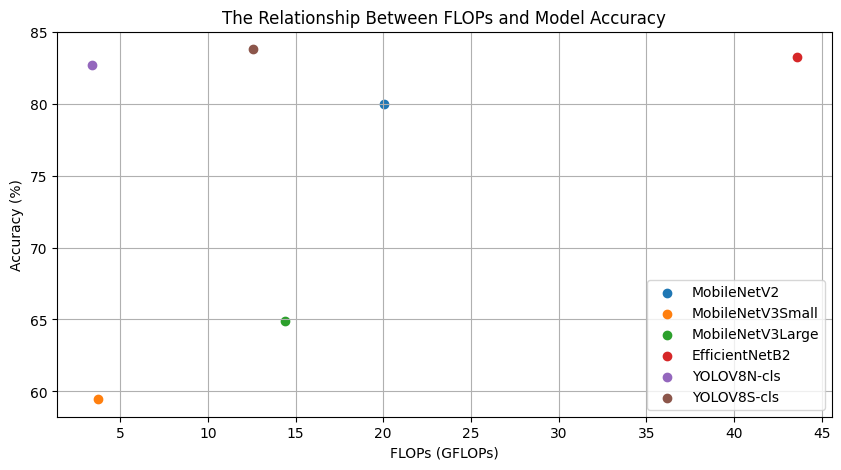

In [ ]:
plot_model_Gflops(array_model, best_accuracies, Glops_model)

In [ ]:
modelyolov8n.info()

YOLOv8n-cls summary: 99 layers, 1,444,693 parameters, 0 gradients, 3.4 GFLOPs


(99, 1444693, 0, 3.3650687999999995)

In [ ]:
# Meminta pengguna memasukkan GFLOPs
total_params_yolov8n = get_gflops_input("Masukkan jumlah total_params: ")
print("Jumlah total_params yang Anda masukkan adalah:", total_params_yolov8n)


Masukkan jumlah total_params: 1444693
Jumlah total_params yang Anda masukkan adalah: 1444693.0


In [ ]:
modelyolov8s.info()

YOLOv8s-cls summary: 99 layers, 5,087,141 parameters, 0 gradients, 12.6 GFLOPs


(99, 5087141, 0, 12.5908992)

In [ ]:
# Meminta pengguna memasukkan GFLOPs
total_params_yolov8s = get_gflops_input("Masukkan jumlah total_params: ")
print("Jumlah total_params yang Anda masukkan adalah:", total_params_yolov8s)


Masukkan jumlah total_params: 5087141
Jumlah total_params yang Anda masukkan adalah: 5087141.0


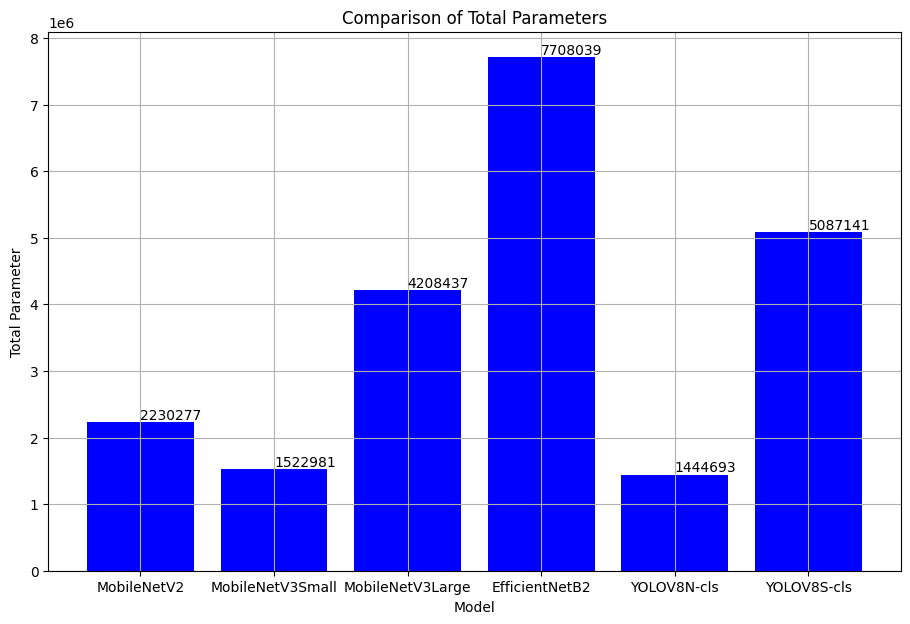

In [ ]:
import matplotlib.pyplot as plt


# Total parameter untuk masing-masing model
total_params = [total_params_mbv2, total_params_mbv3s, total_params_mbv3l, total_params_efb2, total_params_yolov8n, total_params_yolov8s]

# Membuat bar chart
plt.figure(figsize=(11, 7))
bars = plt.bar(array_model, total_params, color='blue')

# Menambahkan judul dan label
plt.title('Comparison of Total Parameters')
plt.xlabel('Model')
plt.ylabel('Total Parameter')

# Menampilkan grid
plt.grid(True)

# Menampilkan angka pada setiap bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval), va='bottom')  # Posisi teks di atas setiap bar

# Menampilkan grafik
plt.show()
